<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Bintangor/Bintangor_SAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_bintangor"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [4]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_bintangor
Rows: 11548
Columns: 16
Shape: (11548, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
4.864101409912109

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,11548.0,5.680615,3.949815,0.000000,2.600000,5.075000,8.000000,23.000000
To,11548.0,6.448785,3.934414,0.200000,3.000000,6.000000,9.000000,23.900000
Interval,11548.0,0.768170,0.290259,0.050000,0.500000,1.000000,1.000000,3.000000
CoreRec,11548.0,1.081167,0.188022,0.200000,1.000000,1.000000,1.090000,3.500000
WetW,11548.0,4.179988,1.862441,0.400000,2.640000,4.259500,5.515000,13.340000
H2O,11548.0,25.032835,14.841084,0.079000,12.402250,25.364500,36.083250,90.147000
DryW,11548.0,3.181767,1.628951,0.156000,1.835000,3.057500,4.336000,11.840000
WTF,11548.0,1.756388,0.571895,0.195304,1.489770,1.723069,1.953043,23.925631
DTF,11548.0,1.335409,0.587918,0.123134,0.992927,1.266640,1.612504,22.471965



Unique GEN_LYR count: 5
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,5803
BRK,2925
SAP,2291
SAPX,312
LIMX,217



Unique Material count: 50
Top Material value counts:


,count
Material,
YLIM,2423
Rlim,1583
ESAP,1572
HGT,933
HSAP,882
RSAP,831
Sap,700
RLIM,380
DNT,365



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [87]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: SAP
Masukkan Material yang ingin difilter (pisahkan dengan koma): Rlim,Sap,ESAP,YLIM,YS,RSAP,HSAP,GS

Filtered rows: 2127


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
0,CS7210128,Bintangor Blok 2 Spasi 50,BINTANGOR,0.00,0.30,0.30,1.15,1.316,9.271,1.194,Rlim,None,ESAP,SAP,1.304705,1.183753
833,CS7210128,Bintangor Blok 2 Spasi 50,BINTANGOR,0.30,1.00,0.70,1.50,4.284,20.635,3.400,Sap,None,SAP,SAP,1.395519,1.107555
955,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,0.85,1.00,0.15,1.35,0.944,40.042,0.566,Sap,None,ESAP,SAP,1.594493,0.956020
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.00,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033
969,CS7210353,Bintangor Blok 1 Spasi 50,BINTANGOR,1.00,2.00,1.00,0.90,4.350,28.966,3.090,Rlim,None,ESAP,SAP,1.653189,1.174334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,CS7210111,Bintangor Blok 2 Spasi 50,BINTANGOR,3.45,4.00,0.55,1.00,2.786,17.014,2.312,HSAP,None,RSAP,SAP,1.732583,1.437808
3830,CS6210138,Bintangor Blok 2 Spasi 25,BINTANGOR,3.45,4.15,0.70,1.00,2.505,36.048,1.602,RSAP,None,SAP,SAP,1.224011,0.782781
3838,CD500105,BINTANGOR BARAT SELATAN,BINTANGOR,3.50,4.05,0.55,1.00,2.145,14.452,1.835,ESAP,None,ESAP,SAP,1.333952,1.141167
3839,CS7210328,Bintangor Blok 1 Spasi 50,BINTANGOR,3.50,4.00,0.50,1.10,2.130,50.235,1.060,Sap,None,ESAP,SAP,1.324624,0.659203


# Filter By Interval

Descriptive statistics for Interval:
Count: 2127
Mean: 0.600174
Standard Error: 0.006166
Median: 0.54
Mode: 1.0
Standard Deviation: 0.284353
Sample Variance: 0.080856
Kurtosis: -0.857334
Skewness: 0.409105
Range: 1.45
Minimum: 0.1
Maximum: 1.55
Sum: 1276.5700000000002
Confidence Level (95%): ±0.012091

Bin calculation:
Freedman–Diaconis -> bins: 21, bin width: 0.069982
Sturges -> bins: 13, bin width: 0.111538


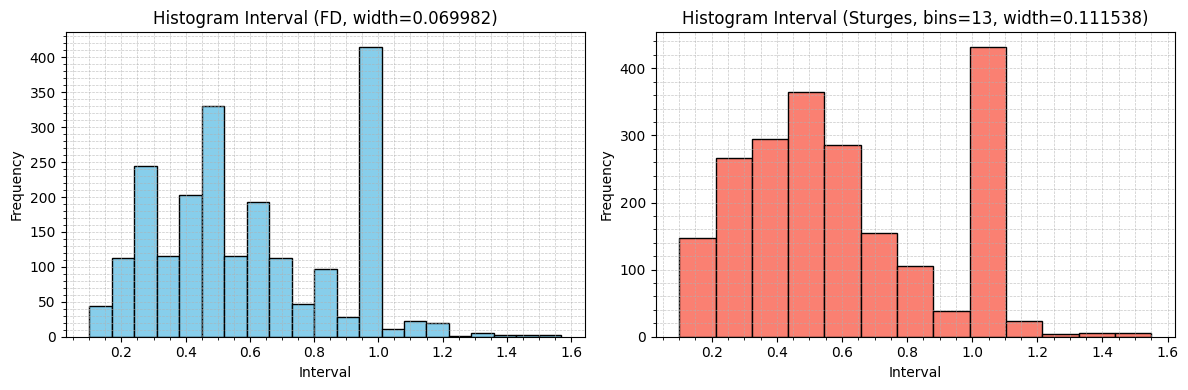


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.100000,0.169982,44
1,0.169982,0.239964,112
2,0.239964,0.309946,244
3,0.309946,0.379928,116
4,0.379928,0.449910,203
5,0.449910,0.519892,331
6,0.519892,0.589874,116
7,0.589874,0.659856,193
8,0.659856,0.729838,113
9,0.729838,0.799821,47



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.100000,0.211538,147
1,0.211538,0.323077,267
2,0.323077,0.434615,295
3,0.434615,0.546154,364
4,0.546154,0.657692,286
5,0.657692,0.769231,154
6,0.769231,0.880769,105
7,0.880769,0.992308,38
8,0.992308,1.103846,432
9,1.103846,1.215385,24


In [88]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [89]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.169982
Masukkan batas atas (is less than or equal to): 0.729838

Filtered rows: 1428


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
0,CS7210128,Bintangor Blok 2 Spasi 50,BINTANGOR,0.00,0.30,0.30,1.15,1.316,9.271,1.194,Rlim,None,ESAP,SAP,1.304705,1.183753
833,CS7210128,Bintangor Blok 2 Spasi 50,BINTANGOR,0.30,1.00,0.70,1.50,4.284,20.635,3.400,Sap,None,SAP,SAP,1.395519,1.107555
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.00,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033
971,CS7210355,Bintangor Blok 1 Spasi 50,BINTANGOR,1.00,1.50,0.50,1.60,2.840,44.366,1.580,YLIM,None,ESAP,SAP,1.214239,0.675527
1725,CS7210126,Bintangor Blok 2 Spasi 50,BINTANGOR,1.10,1.75,0.65,1.00,3.260,18.896,2.644,RSAP,None,SAP,SAP,1.715457,1.391310
1787,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.35,1.65,0.30,1.00,1.556,29.820,1.092,RSAP,None,SAP,SAP,1.774042,1.245022
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.00,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892
1922,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,1.70,2.00,0.30,1.00,1.780,9.831,1.605,RSAP,None,SAP,SAP,2.029432,1.829909
1931,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,1.75,2.00,0.25,1.00,0.894,28.971,0.635,RSAP,None,SAP,SAP,1.223132,0.868779
1935,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,1.80,2.00,0.20,1.00,1.125,36.000,0.720,YLIM,None,ESAP,SAP,1.923970,1.231341


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 1428
Mean: 1.100826
Standard Error: 0.005663
Median: 1.0
Mode: 1.0
Standard Deviation: 0.213996
Sample Variance: 0.045794
Kurtosis: 4.629896
Skewness: 1.935906
Range: 1.8900000000000001
Minimum: 0.4
Maximum: 2.29
Sum: 1571.98
Confidence Level (95%): ±0.011109

Bin calculation:
Freedman–Diaconis -> bins=71, width=0.026641
Sturges -> bins=12, width=0.157500


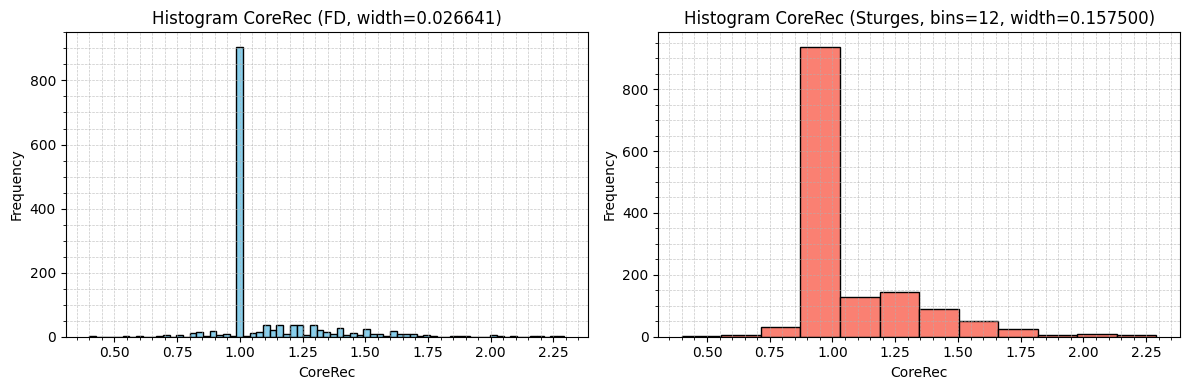


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.400000,0.426641,1
1,0.426641,0.453281,0
2,0.453281,0.479922,0
3,0.479922,0.506563,0
4,0.506563,0.533203,0
...,...,...,...
66,2.158284,2.184925,1
67,2.184925,2.211566,1
68,2.211566,2.238206,0
69,2.238206,2.264847,1



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.4000,0.5575,3
1,0.5575,0.7150,6
2,0.7150,0.8725,31
3,0.8725,1.0300,937
4,1.0300,1.1875,127
5,1.1875,1.3450,143
6,1.3450,1.5025,89
7,1.5025,1.6600,51
8,1.6600,1.8175,24
9,1.8175,1.9750,5


In [90]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [91]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.8725
Masukkan batas atas (is less than or equal to): 1.0300

Filtered rows: 938


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.0,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033
1725,CS7210126,Bintangor Blok 2 Spasi 50,BINTANGOR,1.10,1.75,0.65,1.0,3.260,18.896,2.644,RSAP,None,SAP,SAP,1.715457,1.391310
1787,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.35,1.65,0.30,1.0,1.556,29.820,1.092,RSAP,None,SAP,SAP,1.774042,1.245022
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.0,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892
1922,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,1.70,2.00,0.30,1.0,1.780,9.831,1.605,RSAP,None,SAP,SAP,2.029432,1.829909
1931,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,1.75,2.00,0.25,1.0,0.894,28.971,0.635,RSAP,None,SAP,SAP,1.223132,0.868779
1935,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,1.80,2.00,0.20,1.0,1.125,36.000,0.720,YLIM,None,ESAP,SAP,1.923970,1.231341
1953,CS7210119,Bintangor Blok 2 Spasi 50,BINTANGOR,1.90,2.10,0.20,1.0,0.678,50.442,0.336,ESAP,None,ESAP,SAP,1.159512,0.574626
1963,CD500080,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.20,0.20,1.0,0.633,42.338,0.365,ESAP,None,ESAP,SAP,1.082554,0.624221
1964,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.65,0.65,1.0,2.815,37.300,1.765,ESAP,None,ESAP,SAP,1.481292,0.928768


# Filter By Wet Weight

Tidak ada data dengan Interval=1.0 dan CoreRec=1.0.
Menggunakan seluruh data sebagai acuan residual.

Residual IQR acuan:
Q1: -0.261, Q3: 0.173, IQR: 0.435
Lower margin: -0.913, Upper margin: 0.825


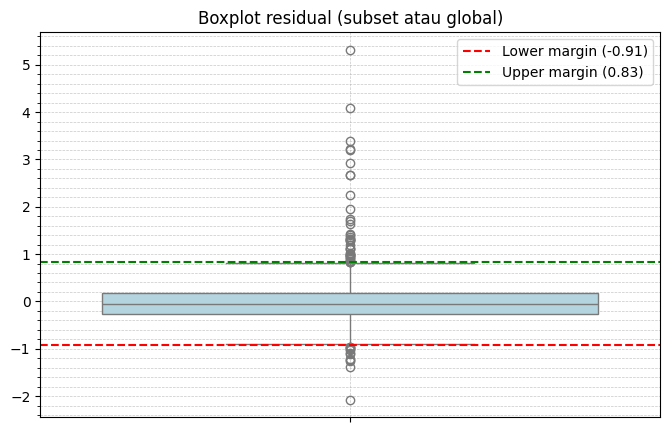

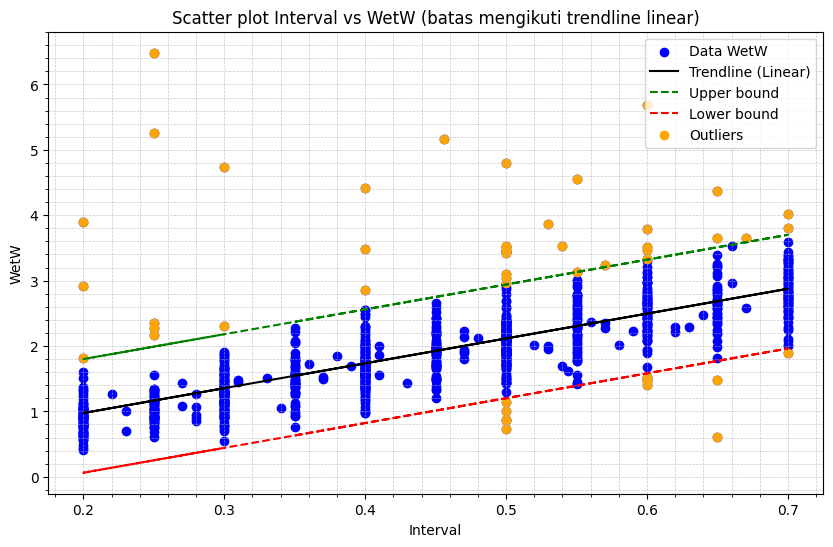


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
         HoleId                       Hill Hill_Group  From    To  Interval  \
3793    CD02478    BINTANGOR BARAT SELATAN  BINTANGOR   3.4  4.00      0.60   
4100   CD500119    BINTANGOR BARAT SELATAN  BINTANGOR   4.0  4.50      0.50   
4684  CS7210043  Bintangor Blok 2 Spasi 50  BINTANGOR   4.0  4.65      0.65   
4739   CD500080      BINTANGOR BARAT UTARA  BINTANGOR   4.1  4.60      0.50   
4924    CD02490    BINTANGOR BARAT SELATAN  BINTANGOR   4.5  5.00      0.50   

      CoreRec   WetW     H2O   DryW Material Layer NEW_LYR GEN_LYR       WTF  \
3793      1.0  1.460  22.137  1.137       GS  None    ESAP     SAP  0.832295   
4100      1.0  1.013  33.366  0.675     ESAP  None    ESAP     SAP  0.692971   
4684      1.0  4.376  52.925  2.060     RSAP  None     SAP     SAP  2.302712   
4739      1.0  0.874  17.620  0.720     RSAP  None    RSAP     SAP  0.597884   
4924      1.0  3.471  28.060  2.497       GS  None     SAP  

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [93]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.0,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033,1.272
1725,CS7210126,Bintangor Blok 2 Spasi 50,BINTANGOR,1.10,1.75,0.65,1.0,3.260,18.896,2.644,RSAP,None,SAP,SAP,1.715457,1.391310,3.260
1787,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.35,1.65,0.30,1.0,1.556,29.820,1.092,RSAP,None,SAP,SAP,1.774042,1.245022,1.556
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.0,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892,2.209
1922,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,1.70,2.00,0.30,1.0,1.780,9.831,1.605,RSAP,None,SAP,SAP,2.029432,1.829909,1.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11481,CS7210075,Bintangor Blok 2 Spasi 50,BINTANGOR,18.10,18.30,0.20,1.0,0.964,49.378,0.488,Sap,None,SAP,SAP,1.648628,0.834575,0.964
11489,CS6210166,Bintangor Blok 2 Spasi 25,BINTANGOR,18.60,19.00,0.40,1.0,2.445,17.301,2.022,HSAP,None,RSAP,SAP,2.090714,1.729007,2.445
11491,CS7210095,Bintangor Blok 2 Spasi 50,BINTANGOR,18.75,19.45,0.70,1.0,4.015,7.796,3.702,HSAP,None,RSAP,SAP,1.961838,1.808898,4.015
11508,CS6210121,Bintangor Blok 2 Spasi 25,BINTANGOR,19.20,19.75,0.55,1.0,1.910,24.346,1.445,HSAP,None,SAP,SAP,1.187808,0.898630,1.910


Tidak ada data dengan Interval=1.0 dan CoreRec=1.0.
Menggunakan seluruh data sebagai acuan residual.

Residual IQR acuan:
Q1: -0.262, Q3: 0.170, IQR: 0.432
Lower margin: -0.910, Upper margin: 0.818


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


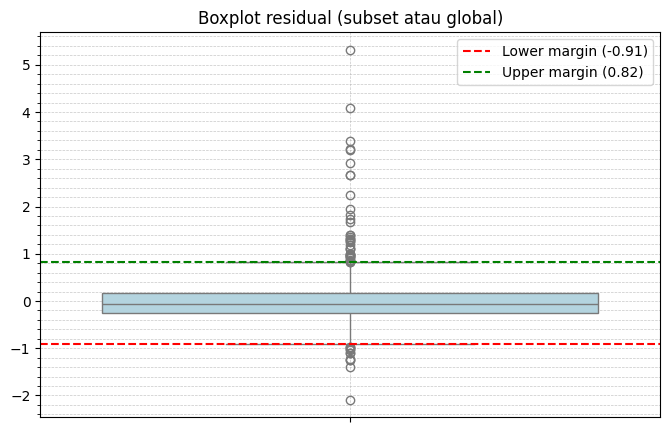

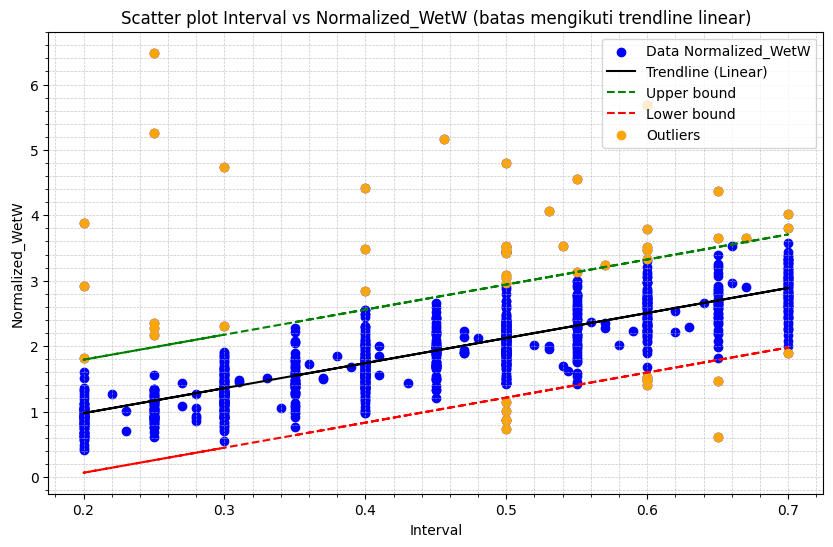

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.0,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033,1.272,1.548939,Normal
1725,CS7210126,Bintangor Blok 2 Spasi 50,BINTANGOR,1.10,1.75,0.65,1.0,3.260,18.896,2.644,RSAP,None,SAP,SAP,1.715457,1.391310,3.260,2.697692,Normal
1787,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.35,1.65,0.30,1.0,1.556,29.820,1.092,RSAP,None,SAP,SAP,1.774042,1.245022,1.556,1.357481,Normal
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.0,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892,2.209,2.582816,Normal
1922,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,1.70,2.00,0.30,1.0,1.780,9.831,1.605,RSAP,None,SAP,SAP,2.029432,1.829909,1.780,1.357481,Normal
1931,CD500074,BINTANGOR BARAT UTARA,BINTANGOR,1.75,2.00,0.25,1.0,0.894,28.971,0.635,RSAP,None,SAP,SAP,1.223132,0.868779,0.894,1.166022,Normal
1935,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,1.80,2.00,0.20,1.0,1.125,36.000,0.720,YLIM,None,ESAP,SAP,1.923970,1.231341,1.125,0.974563,Normal
1953,CS7210119,Bintangor Blok 2 Spasi 50,BINTANGOR,1.90,2.10,0.20,1.0,0.678,50.442,0.336,ESAP,None,ESAP,SAP,1.159512,0.574626,0.678,0.974563,Normal
1963,CD500080,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.20,0.20,1.0,0.633,42.338,0.365,ESAP,None,ESAP,SAP,1.082554,0.624221,0.633,0.974563,Normal
1964,CD500090,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.65,0.65,1.0,2.815,37.300,1.765,ESAP,None,ESAP,SAP,1.481292,0.928768,2.815,2.697692,Normal


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=30, width=0.205130
Sturges -> bins=11, width=0.551909


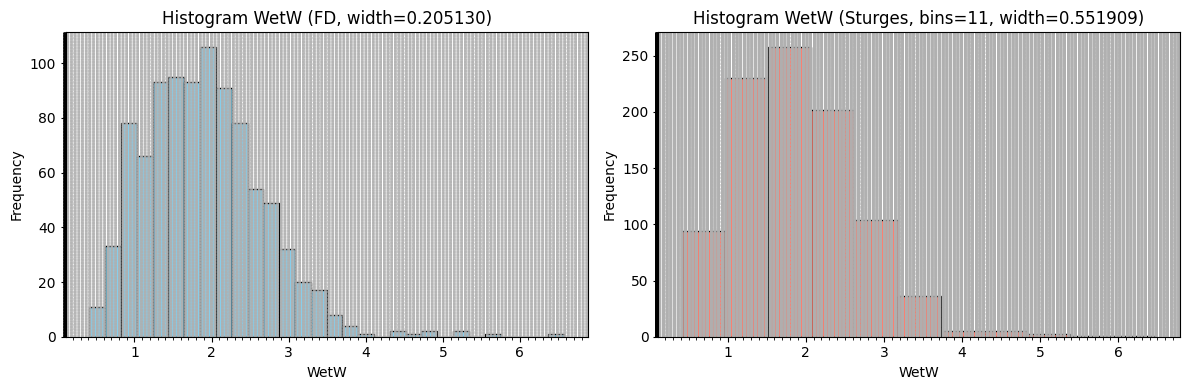


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.415000,0.620130,11
1,0.620130,0.825260,33
2,0.825260,1.030390,78
3,1.030390,1.235520,66
4,1.235520,1.440651,93
5,1.440651,1.645781,95
6,1.645781,1.850911,93
7,1.850911,2.056041,106
8,2.056041,2.261171,91
9,2.261171,2.466301,78



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.415000,0.966909,94
1,0.966909,1.518818,230
2,1.518818,2.070727,258
3,2.070727,2.622636,202
4,2.622636,3.174545,104
5,3.174545,3.726455,36
6,3.726455,4.278364,5
7,4.278364,4.830273,5
8,4.830273,5.382182,2
9,5.382182,5.934091,1


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [96]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 1.235520
Masukkan batas atas (<=): 2.261171

Filtered rows (Normal only): 470


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.0,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033,1.272,1.548939
1787,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.35,1.65,0.30,1.0,1.556,29.820,1.092,RSAP,None,SAP,SAP,1.774042,1.245022,1.556,1.357481
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.0,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892,2.209,2.582816
1922,CD500073,BINTANGOR BARAT SELATAN,BINTANGOR,1.70,2.00,0.30,1.0,1.780,9.831,1.605,RSAP,None,SAP,SAP,2.029432,1.829909,1.780,1.357481
1969,CD500089,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.50,0.50,1.0,2.240,41.518,1.310,ESAP,None,ESAP,SAP,1.532335,0.896142,2.240,2.123315
2699,CS7210353,Bintangor Blok 1 Spasi 50,BINTANGOR,2.00,2.50,0.50,1.0,2.140,30.374,1.490,ESAP,None,SAP,SAP,1.463927,1.019276,2.140,2.123315
2873,CS7210053,Bintangor Blok 2 Spasi 50,BINTANGOR,2.60,3.00,0.40,1.0,1.632,37.868,1.014,Sap,None,ESAP,SAP,1.395519,0.867069,1.632,1.740398
2897,CD500160,BINTANGOR BARAT SELATAN,BINTANGOR,2.60,3.00,0.40,1.0,1.886,7.317,1.748,HSAP,None,RSAP,SAP,1.612714,1.494711,1.886,1.740398
2927,CD500088,BINTANGOR BARAT UTARA,BINTANGOR,2.70,3.00,0.30,1.0,1.245,13.655,1.075,HSAP,None,RSAP,SAP,1.419462,1.225640,1.245,1.357481
2929,CD500064,BINTANGOR BARAT UTARA,BINTANGOR,2.70,3.00,0.30,1.0,1.870,6.684,1.745,RSAP,None,RSAP,SAP,2.132043,1.989527,1.870,1.357481


#Filter By MC


Descriptive statistics for H2O:
Count: 470
Mean: 34.446830
Standard Error: 0.648031
Median: 35.298
Mode: 24.638
Standard Deviation: 14.048970
Sample Variance: 197.373571
Kurtosis: -0.600470
Skewness: -0.014086
Range: 80.306
Minimum: 2.747
Maximum: 83.053
Sum: 16190.01
Confidence Level (95%): ±1.273403

Bin calculation:
Freedman–Diaconis -> bins=15, width=5.672555
Sturges -> bins=10, width=8.030600


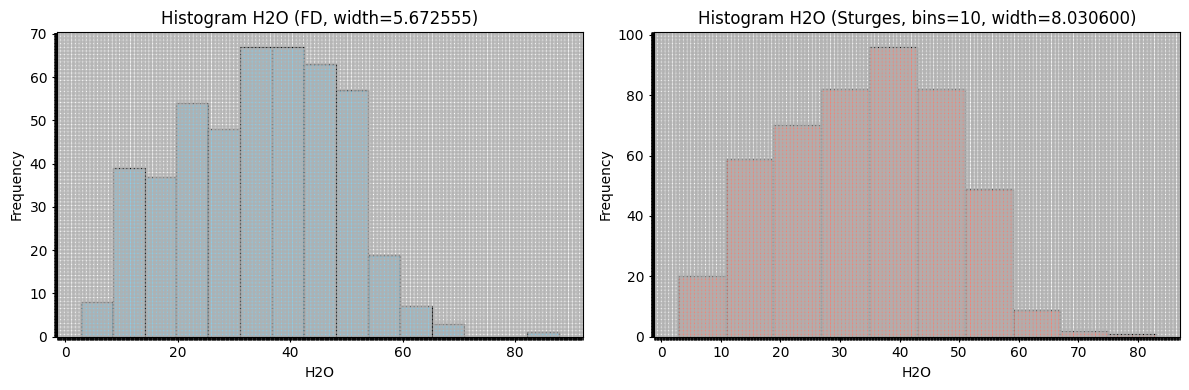


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,2.747000,8.419555,8
1,8.419555,14.092109,39
2,14.092109,19.764664,37
3,19.764664,25.437219,54
4,25.437219,31.109774,48
5,31.109774,36.782328,67
6,36.782328,42.454883,67
7,42.454883,48.127438,63
8,48.127438,53.799992,57
9,53.799992,59.472547,19



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,2.7470,10.7776,20
1,10.7776,18.8082,59
2,18.8082,26.8388,70
3,26.8388,34.8694,82
4,34.8694,42.9000,96
5,42.9000,50.9306,82
6,50.9306,58.9612,49
7,58.9612,66.9918,9
8,66.9918,75.0224,2
9,75.0224,83.0530,1


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [98]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 31.109774
is less than or equal to: 53.799992

Filtered rows (H2O): 254


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.0,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033,1.272,1.548939
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.0,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892,2.209,2.582816
1969,CD500089,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.50,0.50,1.0,2.240,41.518,1.310,ESAP,None,ESAP,SAP,1.532335,0.896142,2.240,2.123315
2873,CS7210053,Bintangor Blok 2 Spasi 50,BINTANGOR,2.60,3.00,0.40,1.0,1.632,37.868,1.014,Sap,None,ESAP,SAP,1.395519,0.867069,1.632,1.740398
3005,CS7210044,Bintangor Blok 2 Spasi 50,BINTANGOR,3.00,3.60,0.60,1.0,2.243,40.348,1.338,YLIM,None,ESAP,SAP,1.278656,0.762747,2.243,2.506233
3007,CS7210116,Bintangor Blok 2 Spasi 50,BINTANGOR,3.00,3.40,0.40,1.0,1.834,45.147,1.006,ESAP,None,ESAP,SAP,1.568249,0.860228,1.834,1.740398
3008,CS6210146,Bintangor Blok 2 Spasi 25,BINTANGOR,3.00,3.50,0.50,1.0,1.882,33.900,1.244,Sap,None,ESAP,SAP,1.287435,0.850993,1.882,2.123315
3009,CS6210150,Bintangor Blok 2 Spasi 25,BINTANGOR,3.00,3.40,0.40,1.0,1.444,49.307,0.732,ESAP,None,ESAP,SAP,1.234761,0.625931,1.444,1.740398
3010,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,3.00,3.50,0.50,1.0,2.070,45.411,1.130,YLIM,None,ESAP,SAP,1.416042,0.773008,2.070,2.123315
3682,CD500097,BINTANGOR BARAT UTARA,BINTANGOR,3.00,3.50,0.50,1.0,1.785,34.510,1.169,ESAP,None,SAP,SAP,1.221079,0.799687,1.785,2.123315


# Filter By DTF


Descriptive statistics for DTF:
Count: 254
Mean: 0.807479
Standard Error: 0.010757
Median: 0.779289314
Mode: 0.766167453
Standard Deviation: 0.171431
Sample Variance: 0.029389
Kurtosis: 0.910567
Skewness: 0.775486
Range: 1.018136213
Minimum: 0.469733617
Maximum: 1.48786983
Sum: 205.099682002
Confidence Level (95%): ±0.021184

Bin calculation:
Freedman–Diaconis -> bins=14, width=0.073222
Sturges -> bins=9, width=0.113126


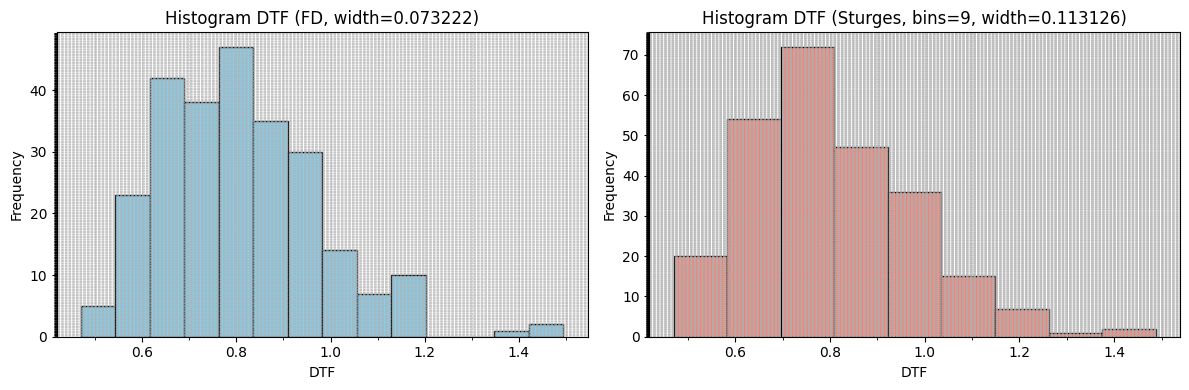


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.469734,0.542956,5
1,0.542956,0.616178,23
2,0.616178,0.689400,42
3,0.689400,0.762622,38
4,0.762622,0.835844,47
5,0.835844,0.909066,35
6,0.909066,0.982288,30
7,0.982288,1.055511,14
8,1.055511,1.128733,7
9,1.128733,1.201955,10



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.469734,0.582860,20
1,0.582860,0.695986,54
2,0.695986,0.809112,72
3,0.809112,0.922239,47
4,0.922239,1.035365,36
5,1.035365,1.148491,15
6,1.148491,1.261617,7
7,1.261617,1.374744,1
8,1.374744,1.487870,2


In [99]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [104]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 0.542956
is less than or equal to: 1.201955

Filtered rows (DTF): 246


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
966,CS7210118,Bintangor Blok 2 Spasi 50,BINTANGOR,1.00,1.35,0.35,1.0,1.272,48.270,0.658,ESAP,None,ESAP,SAP,1.243068,0.643033,1.272,1.548939
1789,CD02496,BINTANGOR BARAT SELATAN,BINTANGOR,1.38,2.00,0.62,1.0,2.209,35.758,1.419,GS,None,ESAP,SAP,1.218652,0.782892,2.209,2.582816
1969,CD500089,BINTANGOR BARAT UTARA,BINTANGOR,2.00,2.50,0.50,1.0,2.240,41.518,1.310,ESAP,None,ESAP,SAP,1.532335,0.896142,2.240,2.123315
2873,CS7210053,Bintangor Blok 2 Spasi 50,BINTANGOR,2.60,3.00,0.40,1.0,1.632,37.868,1.014,Sap,None,ESAP,SAP,1.395519,0.867069,1.632,1.740398
3005,CS7210044,Bintangor Blok 2 Spasi 50,BINTANGOR,3.00,3.60,0.60,1.0,2.243,40.348,1.338,YLIM,None,ESAP,SAP,1.278656,0.762747,2.243,2.506233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,CS7210317,Bintangor Blok 1 Spasi 50,BINTANGOR,6.00,6.35,0.35,1.0,1.445,41.730,0.842,Sap,None,ESAP,SAP,1.412133,0.822848,1.445,1.548939
6444,CS7210312,Bintangor Blok 1 Spasi 50,BINTANGOR,6.00,6.50,0.50,1.0,1.870,52.406,0.890,Sap,None,ESAP,SAP,1.279226,0.608829,1.870,2.123315
6446,CS7210015,Bintangor Blok 2 Spasi 50,BINTANGOR,6.00,6.45,0.45,1.0,2.170,46.359,1.164,ESAP,None,ESAP,SAP,1.649388,0.884741,2.170,1.931857
6456,CS6210073R,Bintangor Blok 2 Spasi 25,BINTANGOR,6.00,6.40,0.40,1.0,1.562,46.479,0.836,RSAP,None,ESAP,SAP,1.335662,0.714862,1.562,1.740398


# SUMMARY

In [105]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 246
Mean: 0.443902
Standard Error: 0.005632
Median: 0.45
Mode: 0.5
Standard Deviation: 0.088328
Sample Variance: 0.007802
Kurtosis: -0.256472
Skewness: 0.041055
Range: 0.44999999999999996
Minimum: 0.25
Maximum: 0.7
Sum: 109.2
Confidence Level (95%): ±0.011093

Descriptive statistics for CoreRec:
Count: 246
Mean: 0.996463
Standard Error: 0.001099
Median: 1.0
Mode: 1.0
Standard Deviation: 0.017241
Sample Variance: 0.000297
Kurtosis: 22.456450
Skewness: -4.740365
Range: 0.13
Minimum: 0.9
Maximum: 1.03
Sum: 245.13
Confidence Level (95%): ±0.002165

Descriptive statistics for WetW:
Count: 246
Mean: 1.763118
Standard Error: 0.018792
Median: 1.78
Mode: 1.72
Standard Deviation: 0.294745
Sample Variance: 0.086875
Kurtosis: -1.160740
Skewness: -0.058012
Range: 1.0219999999999998
Minimum: 1.238
Maximum: 2.26
Sum: 433.72700000000003
Confidence Level (95%): ±0.037015

Descriptive statistics for H2O:
Count: 246
Mean: 41.948634
Standard Error: 0.407573
Med

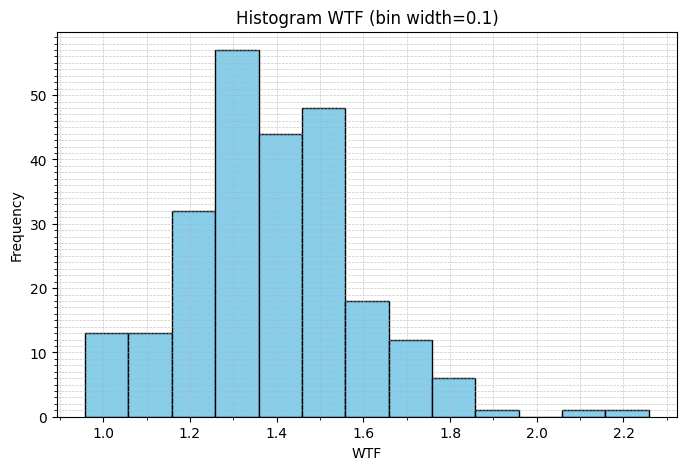


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,0.958279,1.058279,13
1,1.058279,1.158279,13
2,1.158279,1.258279,32
3,1.258279,1.358279,57
4,1.358279,1.458279,44
5,1.458279,1.558279,48
6,1.558279,1.658279,18
7,1.658279,1.758279,12
8,1.758279,1.858279,6
9,1.858279,1.958279,1


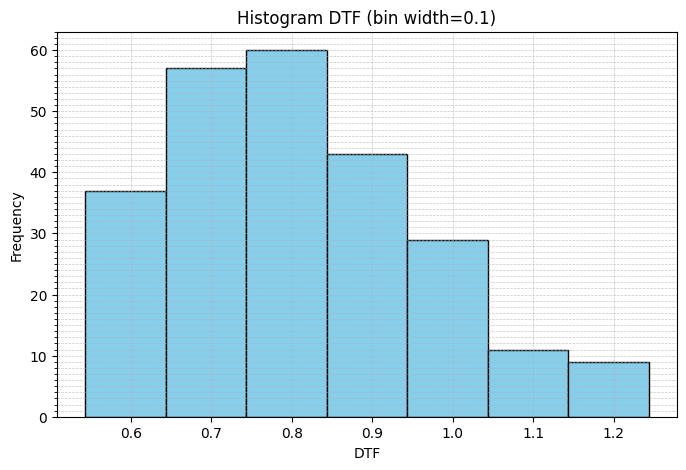


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,0.543285,0.643285,37
1,0.643285,0.743285,57
2,0.743285,0.843285,60
3,0.843285,0.943285,43
4,0.943285,1.043285,29
5,1.043285,1.143285,11
6,1.143285,1.243285,9


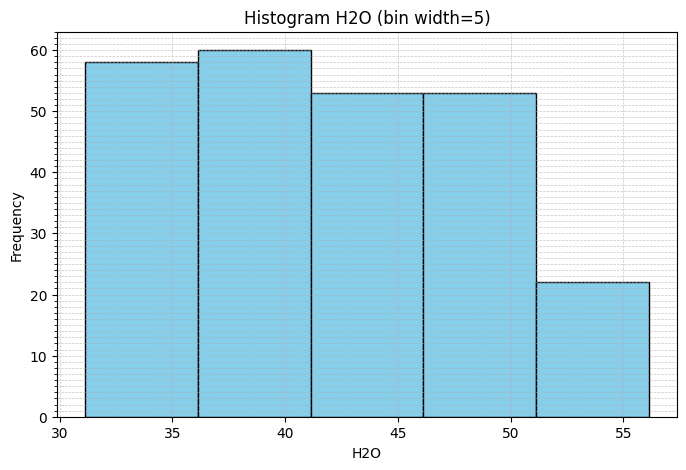


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,31.129,36.129,58
1,36.129,41.129,60
2,41.129,46.129,53
3,46.129,51.129,53
4,51.129,56.129,22


In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [107]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Bintangor
Masukkan GEN_LYR: SAP

Tabel Ringkasan tersimpan sebagai variabel: df_bintangor_sap


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Bintangor,SAP,0.443902,0.996463,1.763118,41.948634,1.024911,1.3862,0.806048
